In [1]:
from descargar_tickets import *
from dateutil.relativedelta import relativedelta
from OptimizarCartera import minimizar_riesgo
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_tickers_crudo = descargar_sp500_mensual(2010,2025, guardar_csv=False)



2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1mo 2010-01-01 -> 2025-12-31)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [4]:
df_tickers_crudo.head()

96073

In [4]:
# Descargo spy
df_spy = descargar_spy(2010,2025)
df_spy['Date'] = pd.to_datetime(df_spy['Date'])
df_spy = df_spy.sort_values(['Ticker', 'Date'])

# Calcular retornos logarítmicos mensuales
df_spy['Return'] = df_spy.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
df_spy = df_spy.dropna(subset=['Return'])


In [5]:
df_spy.head(10)

Price,Date,Close,Ticker,Return
1,2010-02-01,83.330254,SPY,0.030718
2,2010-03-01,88.040817,SPY,0.054989
3,2010-04-01,89.770981,SPY,0.019461
4,2010-05-01,82.638283,SPY,-0.082789
5,2010-06-01,77.991417,SPY,-0.057874
6,2010-07-01,83.714699,SPY,0.070816
7,2010-08-01,79.949158,SPY,-0.046024
8,2010-09-01,86.645134,SPY,0.080430
9,2010-10-01,90.436745,SPY,0.042830
10,2010-11-01,90.436745,SPY,0.000000


In [6]:
df_tickers_crudo['Date'] = pd.to_datetime(df_tickers_crudo['Date'])
# Ordenar
df_tickers_crudo = df_tickers_crudo.sort_values(['Ticker', 'Date'])

# Calcular retornos logarítmicos mensuales
df_tickers_crudo['Return'] = df_tickers_crudo.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
df_tickers_crudo = df_tickers_crudo.dropna(subset=['Return'])


In [7]:
df_tickers_crudo

Price,Date,Close,Ticker,Return
1,2010-02-01,19.993362,A,0.115441
2,2010-03-01,21.855421,A,0.089049
3,2010-04-01,23.043844,A,0.052950
4,2010-05-01,20.565332,A,-0.113792
5,2010-06-01,18.067745,A,-0.129478
...,...,...,...,...
96068,2025-07-01,144.799942,ZTS,-0.067368
96069,2025-08-01,155.857315,ZTS,0.073588
96070,2025-09-01,145.812302,ZTS,-0.066621
96071,2025-10-01,143.590027,ZTS,-0.015358


In [16]:
rebalance_freq = 1  # meses
window = 100         # meses de historial para estimar rendimientos y covarianzas

all_dates = sorted(df_tickers_crudo['Date'].unique())
start_date = pd.Timestamp("2016-01-01")

# Filtrar fechas desde 2024 y seleccionar cada rebalance_freq meses
dates = []
current_date = None
for d in all_dates:
    if d >= start_date:
        if current_date is None:
            # Primera fecha de rebalanceo
            dates.append(d)
            current_date = d
        elif d >= current_date + relativedelta(months=rebalance_freq):
            # Han pasado al menos rebalance_freq meses
            dates.append(d)
            current_date = d

print(f"Fechas de rebalanceo ({len(dates)}): {[d.date() for d in dates[:5]]}...")

# Dataframe para guardar resultados
results = []
benchmark_results = []
portfolio_weights = []  # NUEVO: para guardar los pesos

Fechas de rebalanceo (119): [datetime.date(2016, 1, 1), datetime.date(2016, 2, 1), datetime.date(2016, 3, 1), datetime.date(2016, 4, 1), datetime.date(2016, 5, 1)]...


In [17]:

for d in dates:
    print("Rebalanceo en:", d.date())
    # Ventana de entrenamiento (por ejemplo, últimos 24 meses)
    start_window = d - relativedelta(months=window)
    df_window = df_tickers_crudo[(df_tickers_crudo['Date'] >= start_window) & (df_tickers_crudo['Date'] < d)]
    
    # Validacion nro de observaciones por ticker
    ticker_counts = df_window.groupby('Ticker').size()
    min_observations = 12  # Al menos 12 meses de datos
    valid_tickers = ticker_counts[ticker_counts >= min_observations].index
    df_window = df_window[df_window['Ticker'].isin(valid_tickers)]

    # Calcular rendimientos esperados y covarianza
    mean_return = df_window.groupby('Ticker')['Return'].mean()
    momentum = df_window.groupby('Ticker').apply(lambda x: x.sort_values('Date').tail(3)['Return'].mean())
    mu = 0.5*mean_return + 0.5*momentum
    if mu.isna().any():
        print(f"  ⚠ Warning: NaN en mu para {d.date()}")
        print(f"     Tickers con NaN: {mu[mu.isna()].index.tolist()}")
        mu = mu.fillna(mu.median())  # Rellenar con mediana
    Sigma = df_window.pivot(index='Date', columns='Ticker', values='Return').cov()
    sigma_i = np.sqrt(np.diag(Sigma))       # desviaciones estándar
    T = len(df_window['Date'].unique())      # tamaño muestra (p. ej. meses)
    delta = 1.96 * sigma_i / np.sqrt(T) 
    
    
        # VALIDACIÓN 5: Verificar que todos los inputs son finitos
    # ========================================================================
    if not np.isfinite(mu.values).all():
        print(f"  ⚠ Warning: Valores no finitos en mu")
        mu = mu.replace([np.inf, -np.inf], np.nan).fillna(mu.median())
    
    if not np.isfinite(sigma_i).all():
        print(f"  ⚠ Warning: Valores no finitos en sigma_i")
        sigma_i = np.nan_to_num(sigma_i, nan=sigma_i[np.isfinite(sigma_i)].mean())
    
    if not np.isfinite(delta).all():
        print(f"  ⚠ Warning: Valores no finitos en delta")
        delta = np.nan_to_num(delta, nan=delta[np.isfinite(delta)].mean())
    
    
    
    # Datos para el modelo
    mu_dict = mu.to_dict()
    Sigma_dict = Sigma.stack().to_dict()  # crea un dict con keys (i, j)
    delta_dict = pd.Series(delta, index=Sigma.index).to_dict()
    
    
    # Chequear que no haya nans en mu, Sigma, delta y reemplazar por promedios razonables
    mu_dict = {k: (v if not pd.isna(v) else mean_return.mean()) for k, v in mu_dict.items()}
    delta_dict = {k: (v if not pd.isna(v) else delta.mean()) for k, v in delta_dict.items()}
    Sigma_keys = list(Sigma_dict.keys())
    for key in Sigma_keys:
        if pd.isna(Sigma_dict[key]):
            i, j = key
            Sigma_dict[key] = sigma_i.mean() ** 2 if i == j else 0.0
    
    

    # --- Modelo de optimización (ejemplo simple: media-varianza clásica) ---
    w_opt = minimizar_riesgo(mu_dict, Sigma_dict, delta_dict, aversion=2)
    w_opt = pd.Series(w_opt).reindex(Sigma.columns).fillna(0)
    weights_dict = {'Date': d}
    weights_dict.update(w_opt.to_dict())
    portfolio_weights.append(weights_dict)

    # Retornos siguientes 3 meses
    next_period = df_tickers_crudo[
        (df_tickers_crudo['Date'] >= d) &
        (df_tickers_crudo['Date'] < d + relativedelta(months=rebalance_freq))
    ]

    if next_period.empty:
        continue
    next_returns = next_period.pivot(index='Date', columns='Ticker', values='Return').fillna(0)
    common_tickers = next_returns.columns.intersection(w_opt.index)
    next_returns = next_returns[common_tickers]
    w_opt = w_opt[common_tickers]
    
    if w_opt.sum() == 0:
        continue
    w_opt = w_opt / w_opt.sum()  # Renormalize to sum to 1

    # Calcular rendimiento del portafolio
    port_ret = (next_returns.values @ w_opt.values).sum()
    results.append({'Date': d, 'Portfolio_Return': port_ret})
    
    # Benchmark equiponderado (mismo período)
    # n_tickers = len(next_returns)
    # equal_weights = np.ones(n_tickers) / n_tickers
    # monthly_bench_returns = next_returns.values @ equal_weights
    # bench_ret = monthly_bench_returns.sum()
    # Filtrar retornos del SPY en el mismo rango temporal
    mask_spy = (df_spy['Date'] >= d) & (df_spy['Date'] < d + relativedelta(months=rebalance_freq))
    spy_returns_period = df_spy.loc[mask_spy, 'Return']
    bench_ret = spy_returns_period.sum()
    benchmark_results.append({'Date': d, 'Benchmark_Return': bench_ret})
    
    print(f"  Portfolio: {port_ret:.4f}, Benchmark: {bench_ret:.4f}")



Rebalanceo en: 2016-01-01
  Portfolio: -0.0953, Benchmark: -0.0451
Rebalanceo en: 2016-02-01
  Portfolio: 0.0220, Benchmark: -0.0008
Rebalanceo en: 2016-03-01
  Portfolio: 0.0399, Benchmark: 0.0600
Rebalanceo en: 2016-04-01
  Portfolio: 0.0151, Benchmark: 0.0091
Rebalanceo en: 2016-05-01
  Portfolio: -0.0048, Benchmark: 0.0169
Rebalanceo en: 2016-06-01
  Portfolio: 0.0257, Benchmark: -0.0017
Rebalanceo en: 2016-07-01
  Portfolio: 0.0520, Benchmark: 0.0410
Rebalanceo en: 2016-08-01
  Portfolio: 0.0165, Benchmark: 0.0012
Rebalanceo en: 2016-09-01
  Portfolio: -0.0059, Benchmark: -0.0050
Rebalanceo en: 2016-10-01
  Portfolio: -0.0276, Benchmark: -0.0125
Rebalanceo en: 2016-11-01
  Portfolio: 0.0185, Benchmark: 0.0362
Rebalanceo en: 2016-12-01
  Portfolio: 0.0438, Benchmark: 0.0142
Rebalanceo en: 2017-01-01
  Portfolio: -0.0064, Benchmark: 0.0236
Rebalanceo en: 2017-02-01
  Portfolio: -0.0040, Benchmark: 0.0385
Rebalanceo en: 2017-03-01
  Portfolio: 0.0301, Benchmark: -0.0031
Rebalanceo en

In [19]:
df_results = pd.DataFrame(results).sort_values('Date')
benchmark = pd.DataFrame(benchmark_results).sort_values('Date')

# Merge
df_plot = pd.merge(df_results, benchmark, on='Date', how='inner')

# Retornos acumulados (suma de logs)
df_plot['Cum_Portfolio'] = df_plot['Portfolio_Return'].cumsum()
df_plot['Cum_Benchmark'] = df_plot['Benchmark_Return'].cumsum()

# Convertir a retornos porcentuales para mejor interpretación
df_plot['Cum_Portfolio_Pct'] = np.exp(df_plot['Cum_Portfolio']) - 1
df_plot['Cum_Benchmark_Pct'] = np.exp(df_plot['Cum_Benchmark']) - 1

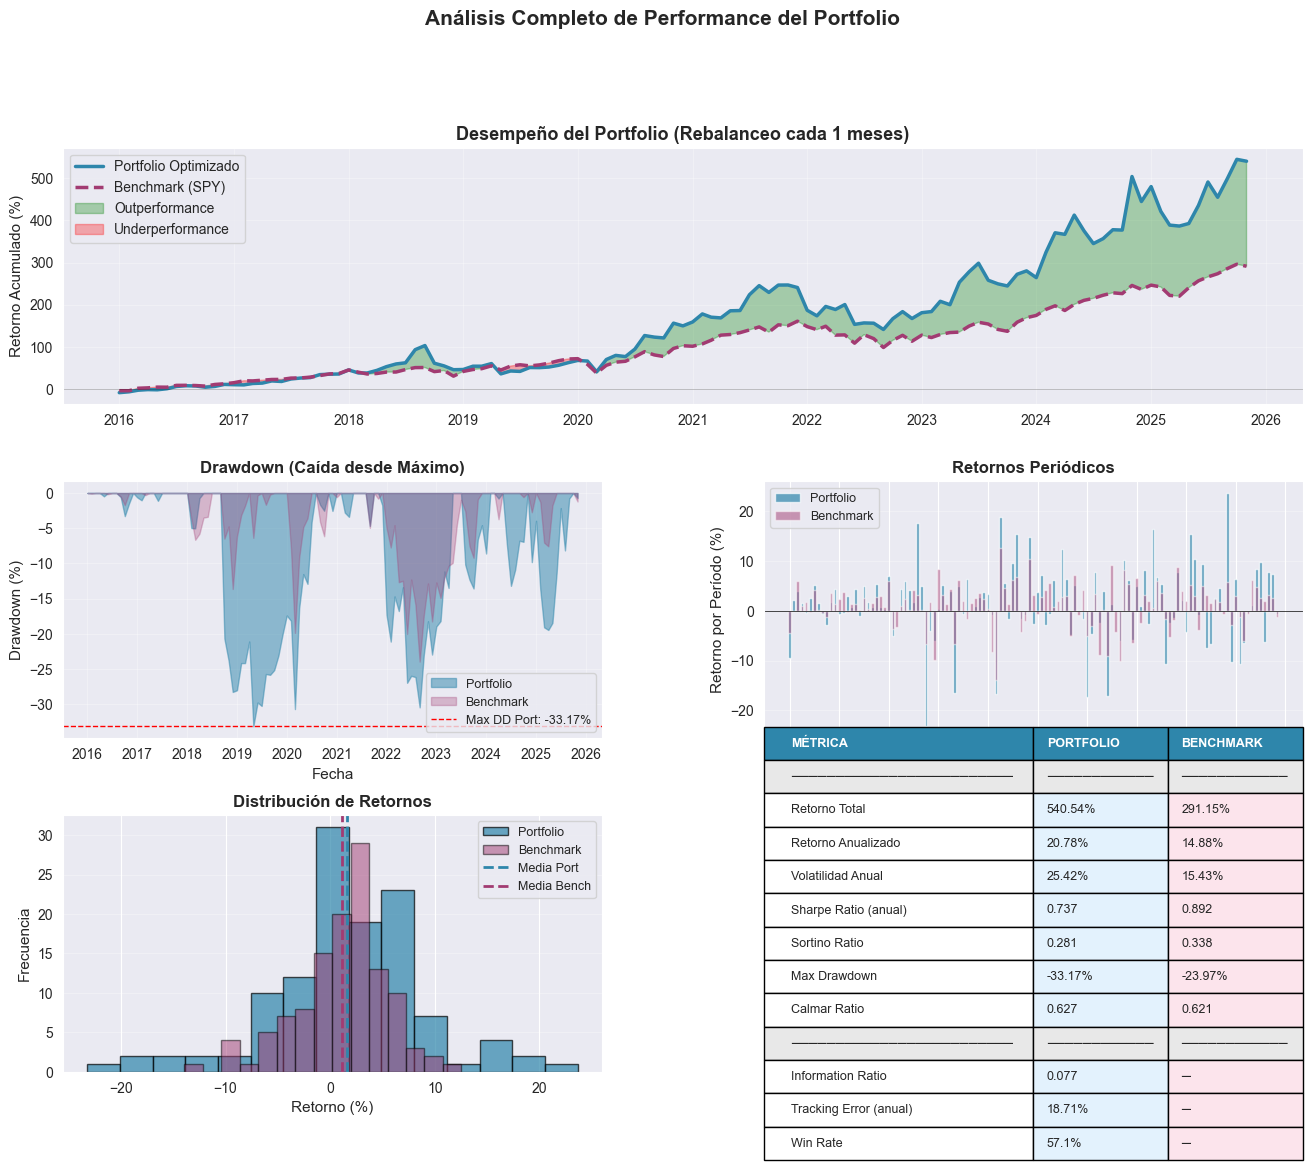


REPORTE COMPLETO DE ANÁLISIS DE PORTFOLIO
Período: 2016-01-01 a 2025-11-01 (9.83 años)
Número de rebalanceos: 119
Frecuencia de rebalanceo: 1 meses

--------------------------------------------------------------------------------
1. RETORNOS
--------------------------------------------------------------------------------
                                     Portfolio       Benchmark      Diferencia
Total                                 540.54%        291.15%        249.39%
Anualizado                             20.78%         14.88%          5.91%
Por período (promedio)                  1.56%          1.15%

--------------------------------------------------------------------------------
2. RIESGO
--------------------------------------------------------------------------------
Volatilidad Anualizada                 25.42%         15.43%
Maximum Drawdown                      -33.17%        -23.97%
  - Fecha del pico             32
  - Fecha del valle            40
Tracking Error (anual

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ============================================================================
# FUNCIONES DE MÉTRICAS
# ============================================================================

def calculate_max_drawdown(cumulative_returns):
    """
    Calcula el Maximum Drawdown (máxima caída desde el pico más alto)
    
    Returns:
        max_dd: Maximum drawdown (valor negativo)
        peak_date: Fecha del pico antes de la mayor caída
        valley_date: Fecha del valle (punto más bajo)
    """
    cumulative_wealth = 1 + cumulative_returns
    running_max = cumulative_wealth.expanding().max()
    drawdown = (cumulative_wealth - running_max) / running_max
    
    max_dd = drawdown.min()
    valley_idx = drawdown.idxmin()
    peak_idx = cumulative_wealth[:valley_idx].idxmax()
    
    return max_dd, peak_idx, valley_idx

def calculate_calmar_ratio(total_return, max_drawdown, years):
    """
    Calmar Ratio = Retorno Anualizado / |Maximum Drawdown|
    Mide retorno ajustado por riesgo de caídas extremas
    """
    annualized_return = (1 + total_return) ** (1/years) - 1
    if max_drawdown == 0:
        return np.inf
    return annualized_return / abs(max_drawdown)

def calculate_sortino_ratio(returns, rf=0):
    """
    Sortino Ratio = (Retorno medio - rf) / Desviación de retornos negativos
    Similar a Sharpe pero solo penaliza volatilidad a la baja
    """
    excess_return = returns.mean() - rf
    downside_returns = returns[returns < rf]
    if len(downside_returns) == 0 or downside_returns.std() == 0:
        return np.inf
    downside_std = downside_returns.std()
    return excess_return / downside_std

def calculate_information_ratio(portfolio_returns, benchmark_returns):
    """
    Information Ratio = Exceso de retorno medio / Tracking Error
    Mide consistencia del outperformance vs benchmark
    """
    excess_returns = portfolio_returns - benchmark_returns
    tracking_error = excess_returns.std()
    if tracking_error == 0:
        return np.inf
    return excess_returns.mean() / tracking_error

def calculate_win_rate(portfolio_returns, benchmark_returns):
    """
    % de períodos en que el portfolio superó al benchmark
    """
    wins = (portfolio_returns > benchmark_returns).sum()
    total = len(portfolio_returns)
    return wins / total if total > 0 else 0

# ============================================================================
# CÁLCULO DE MÉTRICAS
# ============================================================================

# Asumiendo que ya tienes df_plot con Portfolio_Return y Benchmark_Return
# df_plot debe tener columnas: Date, Portfolio_Return, Benchmark_Return, 
#                              Cum_Portfolio_Pct, Cum_Benchmark_Pct

# Período de análisis
start_date = df_plot['Date'].iloc[0]
end_date = df_plot['Date'].iloc[-1]
years = (end_date - start_date).days / 365.25

# Retornos totales
total_return_port = df_plot['Cum_Portfolio_Pct'].iloc[-1]
total_return_bench = df_plot['Cum_Benchmark_Pct'].iloc[-1]

# Retornos anualizados
ann_return_port = (1 + total_return_port) ** (1/years) - 1
ann_return_bench = (1 + total_return_bench) ** (1/years) - 1

# Volatilidad (desviación estándar de retornos por período)
vol_port = df_plot['Portfolio_Return'].std()
vol_bench = df_plot['Benchmark_Return'].std()

# Volatilidad anualizada (asumiendo rebalance_freq meses)
# Si rebalance_freq=3 (trimestral), hay 4 períodos por año
periods_per_year = 12 / rebalance_freq
ann_vol_port = vol_port * np.sqrt(periods_per_year)
ann_vol_bench = vol_bench * np.sqrt(periods_per_year)

# Maximum Drawdown
max_dd_port, peak_date_port, valley_date_port = calculate_max_drawdown(df_plot['Cum_Portfolio_Pct'])
max_dd_bench, peak_date_bench, valley_date_bench = calculate_max_drawdown(df_plot['Cum_Benchmark_Pct'])

# Sharpe Ratio (asumiendo rf=0 para simplificar)
sharpe_port = (df_plot['Portfolio_Return'].mean()) / vol_port if vol_port > 0 else 0
sharpe_bench = (df_plot['Benchmark_Return'].mean()) / vol_bench if vol_bench > 0 else 0

# Sharpe anualizado
ann_sharpe_port = sharpe_port * np.sqrt(periods_per_year)
ann_sharpe_bench = sharpe_bench * np.sqrt(periods_per_year)

# Sortino Ratio
sortino_port = calculate_sortino_ratio(df_plot['Portfolio_Return'])
sortino_bench = calculate_sortino_ratio(df_plot['Benchmark_Return'])

# Calmar Ratio
calmar_port = calculate_calmar_ratio(total_return_port, max_dd_port, years)
calmar_bench = calculate_calmar_ratio(total_return_bench, max_dd_bench, years)

# Information Ratio
info_ratio = calculate_information_ratio(df_plot['Portfolio_Return'], df_plot['Benchmark_Return'])

# Win Rate
win_rate = calculate_win_rate(df_plot['Portfolio_Return'], df_plot['Benchmark_Return'])

# Tracking Error
tracking_error = (df_plot['Portfolio_Return'] - df_plot['Benchmark_Return']).std()
ann_tracking_error = tracking_error * np.sqrt(periods_per_year)

# ============================================================================
# VISUALIZACIÓN
# ============================================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Retornos Acumulados
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
         label='Portfolio Optimizado', linewidth=2.5, color='#2E86AB')
ax1.plot(df_plot['Date'], df_plot['Cum_Benchmark_Pct'] * 100, 
         label='Benchmark (SPY)', linewidth=2.5, color='#A23B72', linestyle='--')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
                  df_plot['Cum_Benchmark_Pct'] * 100, 
                  where=(df_plot['Cum_Portfolio_Pct'] >= df_plot['Cum_Benchmark_Pct']),
                  alpha=0.3, color='green', label='Outperformance')
ax1.fill_between(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
                  df_plot['Cum_Benchmark_Pct'] * 100, 
                  where=(df_plot['Cum_Portfolio_Pct'] < df_plot['Cum_Benchmark_Pct']),
                  alpha=0.3, color='red', label='Underperformance')
ax1.set_ylabel('Retorno Acumulado (%)', fontsize=11)
ax1.set_title(f'Desempeño del Portfolio (Rebalanceo cada {rebalance_freq} meses)', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Drawdown
ax2 = fig.add_subplot(gs[1, 0])
cumulative_wealth_port = 1 + df_plot['Cum_Portfolio_Pct']
running_max_port = cumulative_wealth_port.expanding().max()
drawdown_port = (cumulative_wealth_port - running_max_port) / running_max_port * 100

cumulative_wealth_bench = 1 + df_plot['Cum_Benchmark_Pct']
running_max_bench = cumulative_wealth_bench.expanding().max()
drawdown_bench = (cumulative_wealth_bench - running_max_bench) / running_max_bench * 100

ax2.fill_between(df_plot['Date'], 0, drawdown_port, alpha=0.5, color='#2E86AB', label='Portfolio')
ax2.fill_between(df_plot['Date'], 0, drawdown_bench, alpha=0.3, color='#A23B72', label='Benchmark')
ax2.axhline(y=max_dd_port * 100, color='red', linestyle='--', linewidth=1, 
            label=f'Max DD Port: {max_dd_port*100:.2f}%')
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.set_xlabel('Fecha', fontsize=11)
ax2.set_title('Drawdown (Caída desde Máximo)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Retornos por Período
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(df_plot['Date'], df_plot['Portfolio_Return'] * 100, 
        alpha=0.7, color='#2E86AB', label='Portfolio', width=20)
ax3.bar(df_plot['Date'], df_plot['Benchmark_Return'] * 100, 
        alpha=0.5, color='#A23B72', label='Benchmark', width=20)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Retorno por Período (%)', fontsize=11)
ax3.set_xlabel('Fecha', fontsize=11)
ax3.set_title('Retornos Periódicos', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Distribución de Retornos
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(df_plot['Portfolio_Return'] * 100, bins=15, alpha=0.7, 
         color='#2E86AB', label='Portfolio', edgecolor='black')
ax4.hist(df_plot['Benchmark_Return'] * 100, bins=15, alpha=0.5, 
         color='#A23B72', label='Benchmark', edgecolor='black')
ax4.axvline(df_plot['Portfolio_Return'].mean() * 100, color='#2E86AB', 
            linestyle='--', linewidth=2, label='Media Port')
ax4.axvline(df_plot['Benchmark_Return'].mean() * 100, color='#A23B72', 
            linestyle='--', linewidth=2, label='Media Bench')
ax4.set_xlabel('Retorno (%)', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Retornos', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Tabla de Métricas
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

metrics_data = [
    ['MÉTRICA', 'PORTFOLIO', 'BENCHMARK'],
    ['─' * 25, '─' * 12, '─' * 12],
    ['Retorno Total', f'{total_return_port*100:.2f}%', f'{total_return_bench*100:.2f}%'],
    ['Retorno Anualizado', f'{ann_return_port*100:.2f}%', f'{ann_return_bench*100:.2f}%'],
    ['Volatilidad Anual', f'{ann_vol_port*100:.2f}%', f'{ann_vol_bench*100:.2f}%'],
    ['Sharpe Ratio (anual)', f'{ann_sharpe_port:.3f}', f'{ann_sharpe_bench:.3f}'],
    ['Sortino Ratio', f'{sortino_port:.3f}', f'{sortino_bench:.3f}'],
    ['Max Drawdown', f'{max_dd_port*100:.2f}%', f'{max_dd_bench*100:.2f}%'],
    ['Calmar Ratio', f'{calmar_port:.3f}', f'{calmar_bench:.3f}'],
    ['─' * 25, '─' * 12, '─' * 12],
    ['Information Ratio', f'{info_ratio:.3f}', '─'],
    ['Tracking Error (anual)', f'{ann_tracking_error*100:.2f}%', '─'],
    ['Win Rate', f'{win_rate*100:.1f}%', '─'],
]

table = ax5.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Estilo de la tabla
for i in range(len(metrics_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#2E86AB')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1 or i == 9:  # Separadores
            cell.set_facecolor('#E8E8E8')
        else:
            if j == 1:  # Columna Portfolio
                cell.set_facecolor('#E3F2FD')
            elif j == 2:  # Columna Benchmark
                cell.set_facecolor('#FCE4EC')

plt.suptitle('Análisis Completo de Performance del Portfolio', 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

# ============================================================================
# REPORTE TEXTUAL DETALLADO
# ============================================================================

print("\n" + "="*80)
print("REPORTE COMPLETO DE ANÁLISIS DE PORTFOLIO")
print("="*80)
print(f"Período: {start_date.date()} a {end_date.date()} ({years:.2f} años)")
print(f"Número de rebalanceos: {len(df_plot)}")
print(f"Frecuencia de rebalanceo: {rebalance_freq} meses")

print("\n" + "-"*80)
print("1. RETORNOS")
print("-"*80)
print(f"{'':30} {'Portfolio':>15} {'Benchmark':>15} {'Diferencia':>15}")
print(f"{'Total':30} {total_return_port:>14.2%} {total_return_bench:>14.2%} {total_return_port-total_return_bench:>14.2%}")
print(f"{'Anualizado':30} {ann_return_port:>14.2%} {ann_return_bench:>14.2%} {ann_return_port-ann_return_bench:>14.2%}")
print(f"{'Por período (promedio)':30} {df_plot['Portfolio_Return'].mean():>14.2%} {df_plot['Benchmark_Return'].mean():>14.2%}")

print("\n" + "-"*80)
print("2. RIESGO")
print("-"*80)
print(f"{'Volatilidad Anualizada':30} {ann_vol_port:>14.2%} {ann_vol_bench:>14.2%}")
print(f"{'Maximum Drawdown':30} {max_dd_port:>14.2%} {max_dd_bench:>14.2%}")
print(f"{'  - Fecha del pico':30} {peak_date_port}")
print(f"{'  - Fecha del valle':30} {valley_date_port}")
print(f"{'Tracking Error (anual)':30} {ann_tracking_error:>14.2%}")

print("\n" + "-"*80)
print("3. RATIOS DE RIESGO-RETORNO")
print("-"*80)
print(f"{'Sharpe Ratio (anualizado)':30} {ann_sharpe_port:>14.3f} {ann_sharpe_bench:>14.3f}")
print(f"{'Sortino Ratio':30} {sortino_port:>14.3f} {sortino_bench:>14.3f}")
print(f"{'Calmar Ratio':30} {calmar_port:>14.3f} {calmar_bench:>14.3f}")
print(f"{'Information Ratio':30} {info_ratio:>14.3f}")

print("\n" + "-"*80)
print("4. CONSISTENCIA")
print("-"*80)
print(f"{'Win Rate (% períodos ganadores)':30} {win_rate:>14.1%}")
print(f"{'Períodos positivos (Portfolio)':30} {(df_plot['Portfolio_Return'] > 0).sum():>14d} / {len(df_plot)}")
print(f"{'Períodos positivos (Benchmark)':30} {(df_plot['Benchmark_Return'] > 0).sum():>14d} / {len(df_plot)}")

print("\n" + "-"*80)
print("5. VALOR DE INVERSIÓN (Base $100,000)")
print("-"*80)
inversion = 100_000
valor_final_port = inversion * (1 + total_return_port)
valor_final_bench = inversion * (1 + total_return_bench)
print(f"{'Valor final Portfolio':30} ${valor_final_port:>14,.2f}")
print(f"{'Valor final Benchmark':30} ${valor_final_bench:>14,.2f}")
print(f"{'Ganancia Portfolio':30} ${valor_final_port - inversion:>14,.2f}")
print(f"{'Ganancia Benchmark':30} ${valor_final_bench - inversion:>14,.2f}")
print(f"{'Ganancia adicional':30} ${valor_final_port - valor_final_bench:>14,.2f}")

print("\n" + "="*80)
print("INTERPRETACIÓN DE MÉTRICAS")
print("="*80)
print("""
📊 SHARPE RATIO (anualizado): Mide retorno por unidad de riesgo total
   - Mayor a 1.0 = Bueno | Mayor a 2.0 = Muy bueno | Mayor a 3.0 = Excelente
   - Tu portfolio: {:.2f}

📉 SORTINO RATIO: Similar a Sharpe pero solo penaliza volatilidad negativa
   - Mejor métrica si te preocupan solo las caídas, no la volatilidad al alza
   - Tu portfolio: {:.2f}

💥 MAXIMUM DRAWDOWN: Peor caída desde un pico hasta el valle
   - Responde: "¿Cuánto perdí en el peor momento?"
   - Tu portfolio: {:.2%} (del {} al {})

🎯 CALMAR RATIO: Retorno anualizado / |Max Drawdown|
   - Mide cuánto retorno obtienes por cada punto de caída máxima
   - Mayor a 1.0 = Bueno
   - Tu portfolio: {:.2f}

📈 INFORMATION RATIO: Exceso de retorno / Tracking Error
   - Mide consistencia del outperformance vs benchmark
   - Mayor a 0.5 = Bueno | Mayor a 1.0 = Excelente
   - Tu portfolio: {:.2f}

🎲 WIN RATE: % de períodos en que superaste al benchmark
   - Tu portfolio: {:.1%}

⚠️ TRACKING ERROR: Volatilidad del exceso de retorno vs benchmark
   - Mide cuán diferente es tu estrategia del benchmark
   - Tu portfolio: {:.2%}
""".format(
    ann_sharpe_port,
    sortino_port,
    max_dd_port, peak_date_port, valley_date_port,
    calmar_port,
    info_ratio,
    win_rate,
    ann_tracking_error
))

print("="*80)

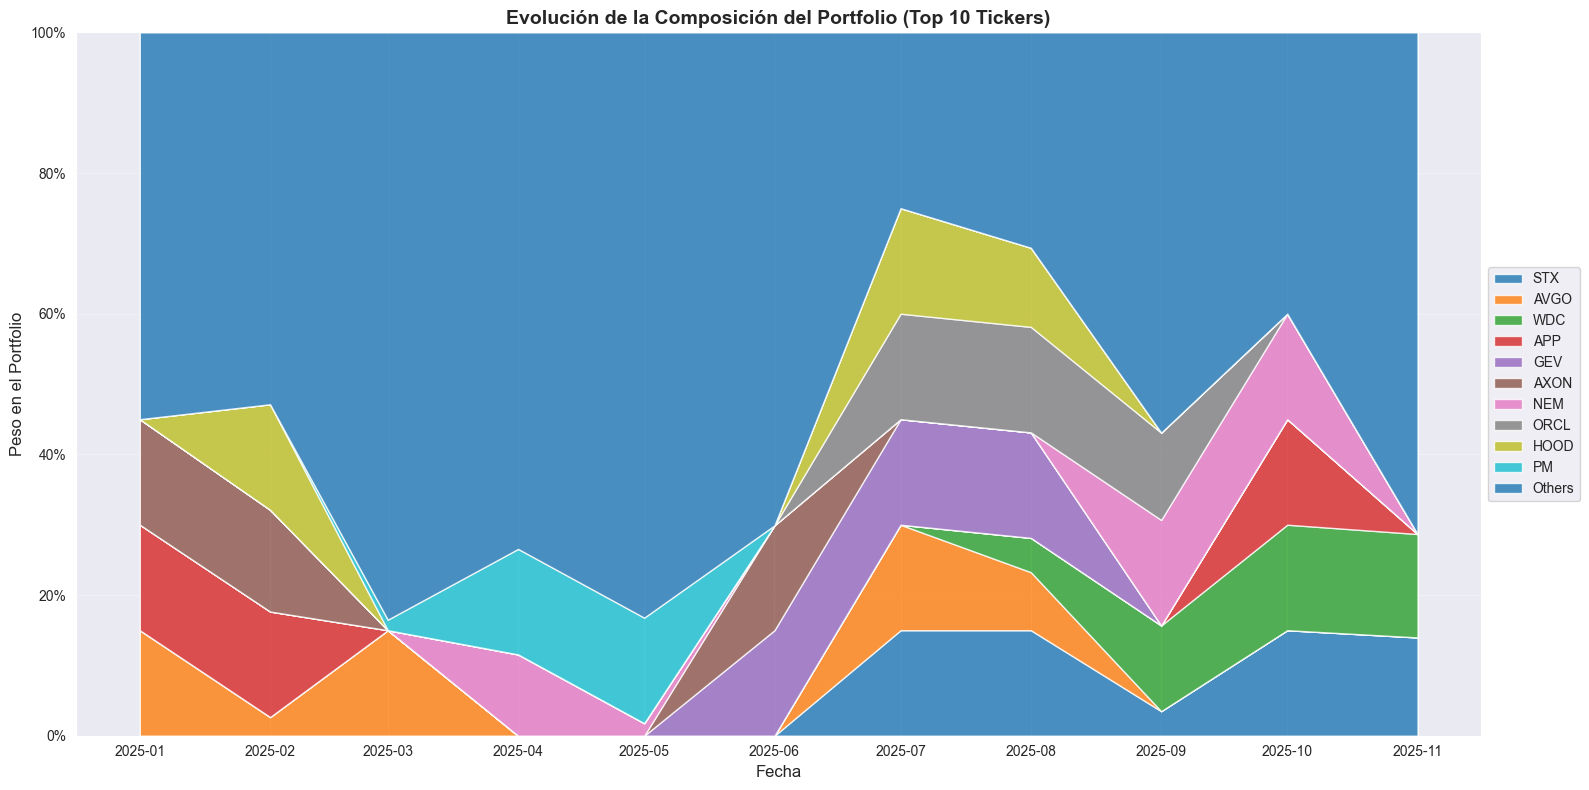

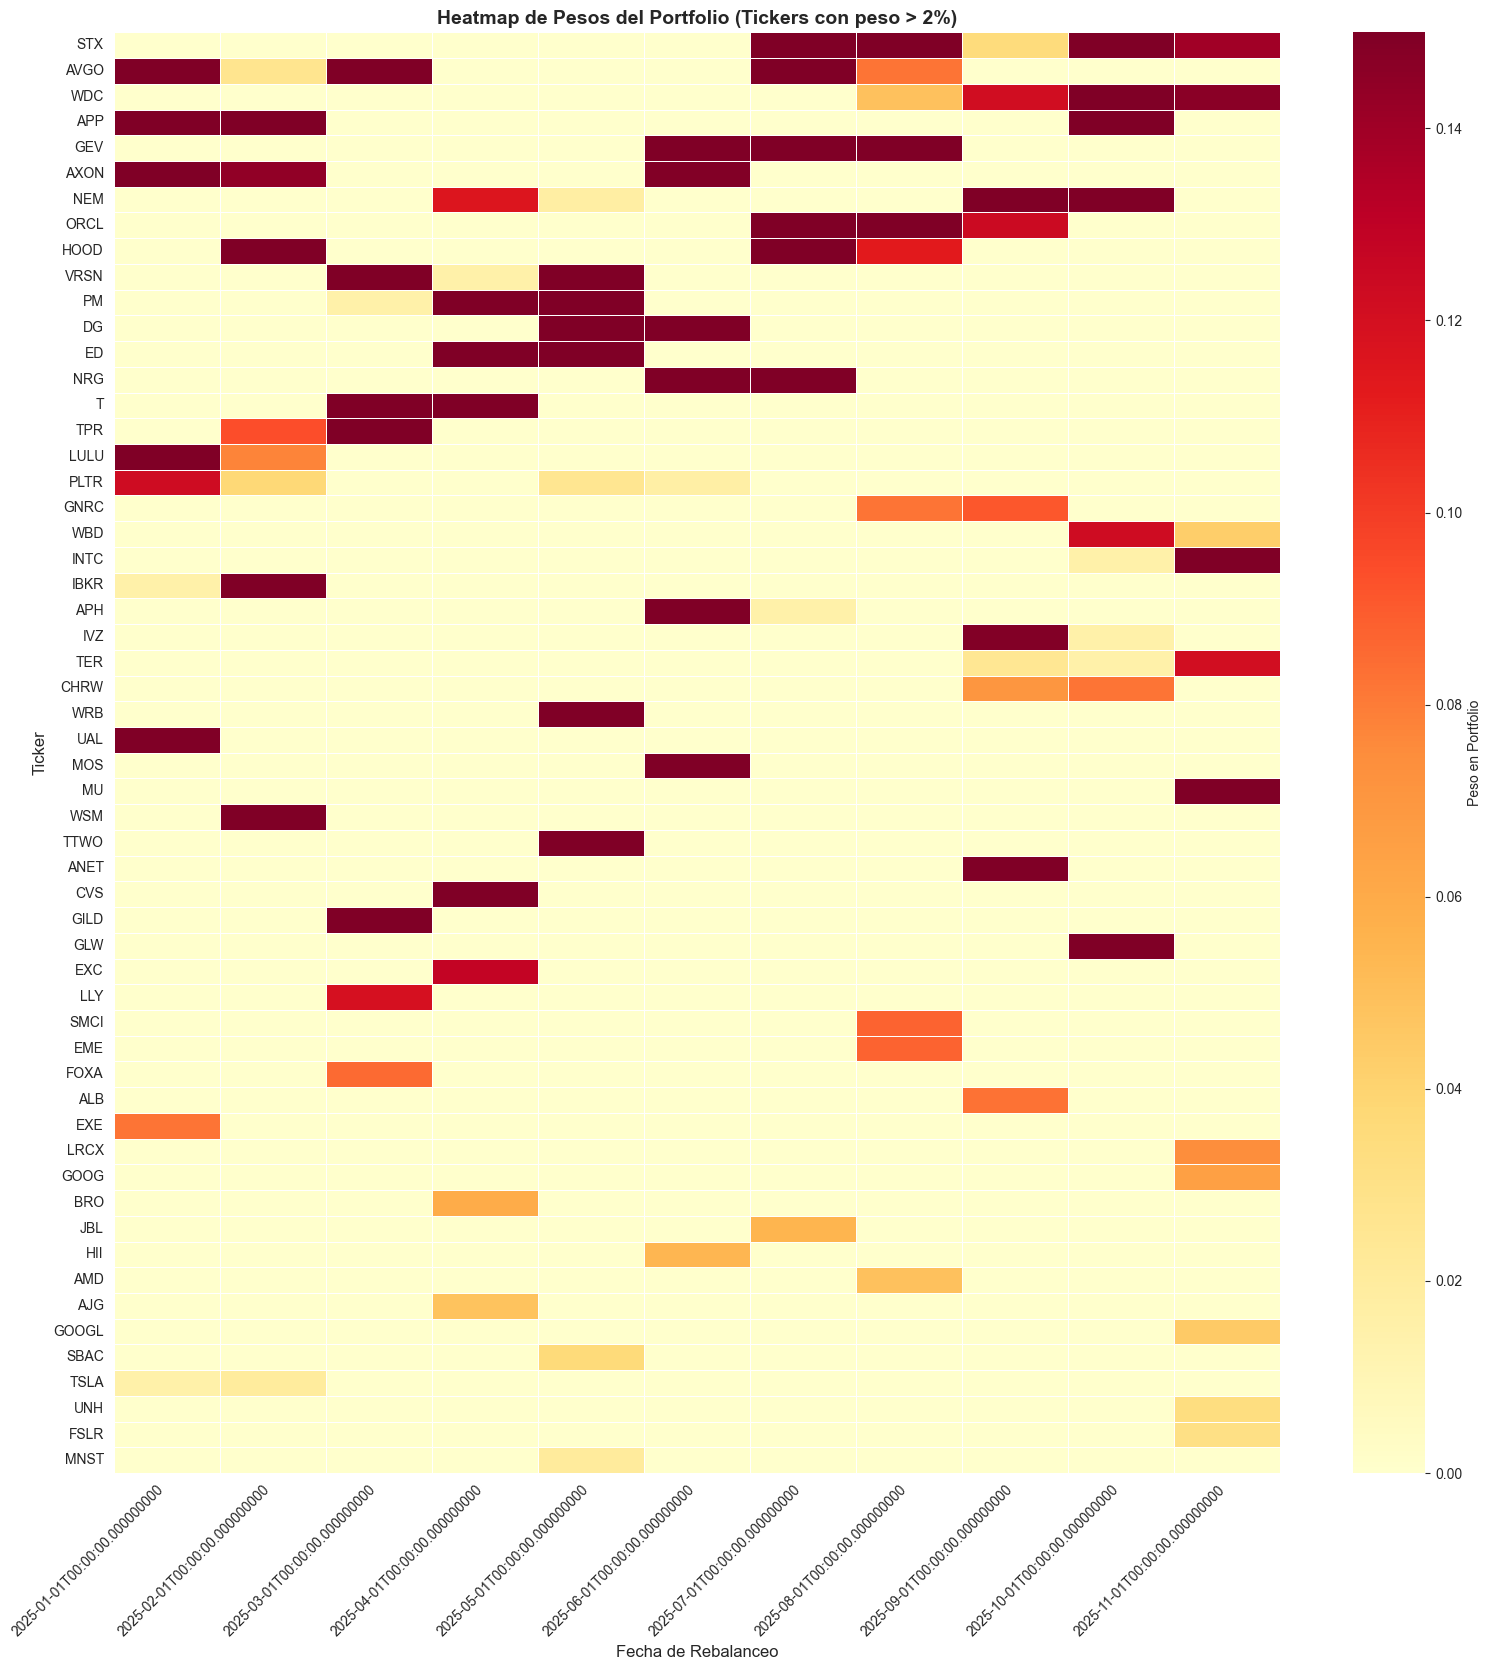

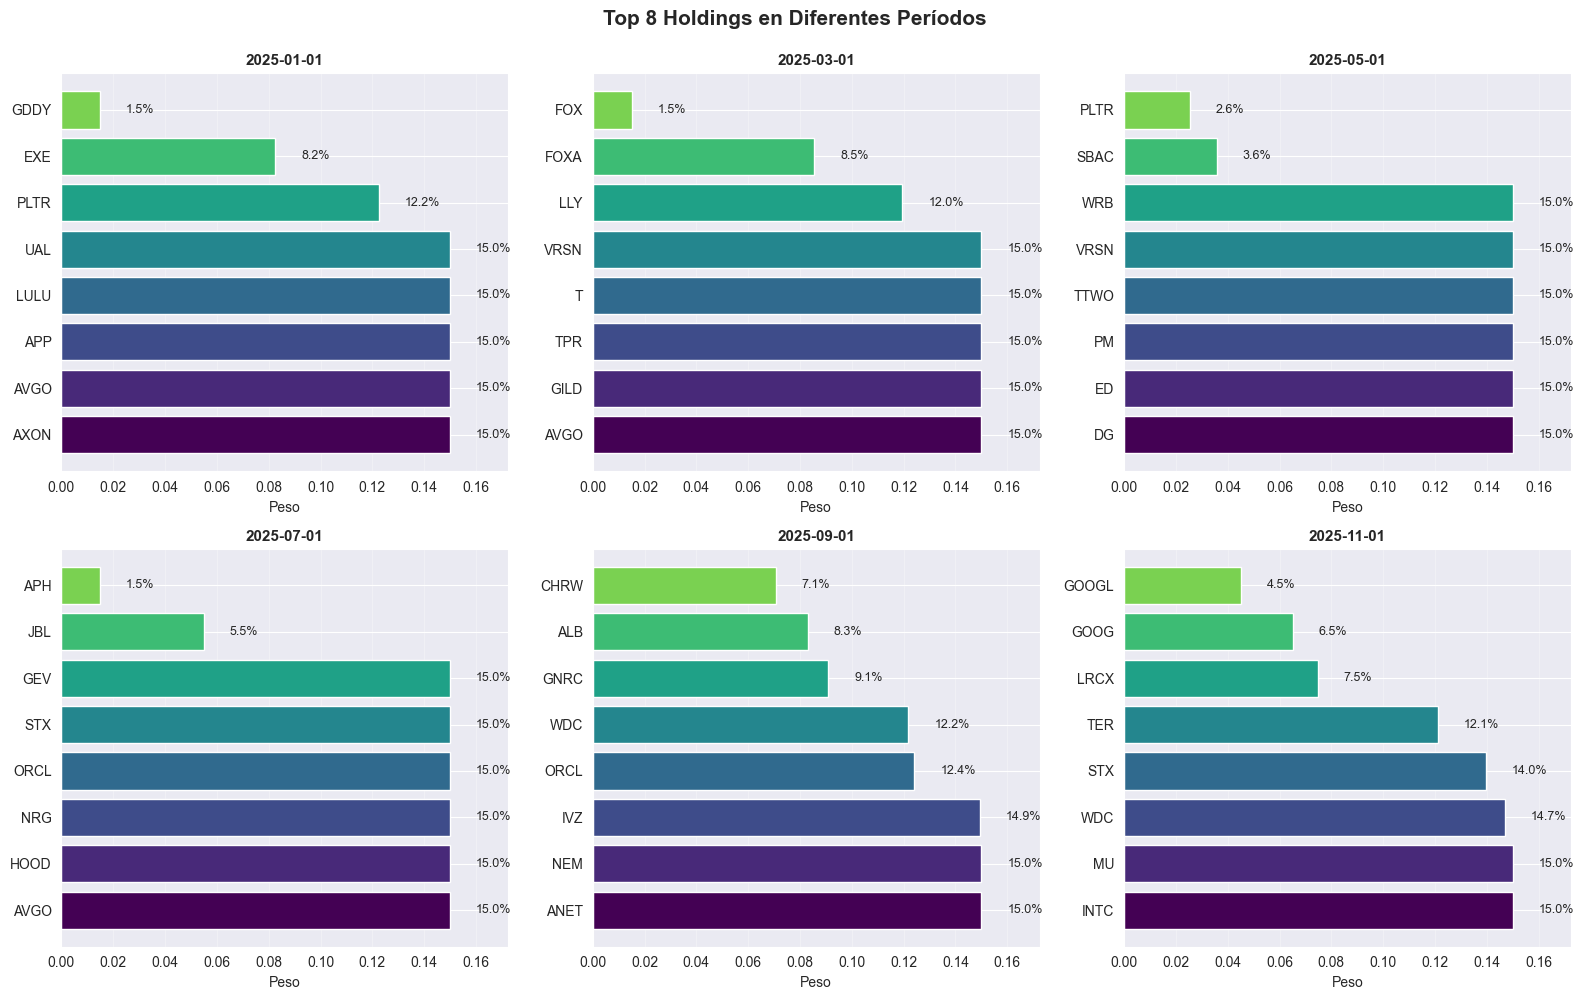

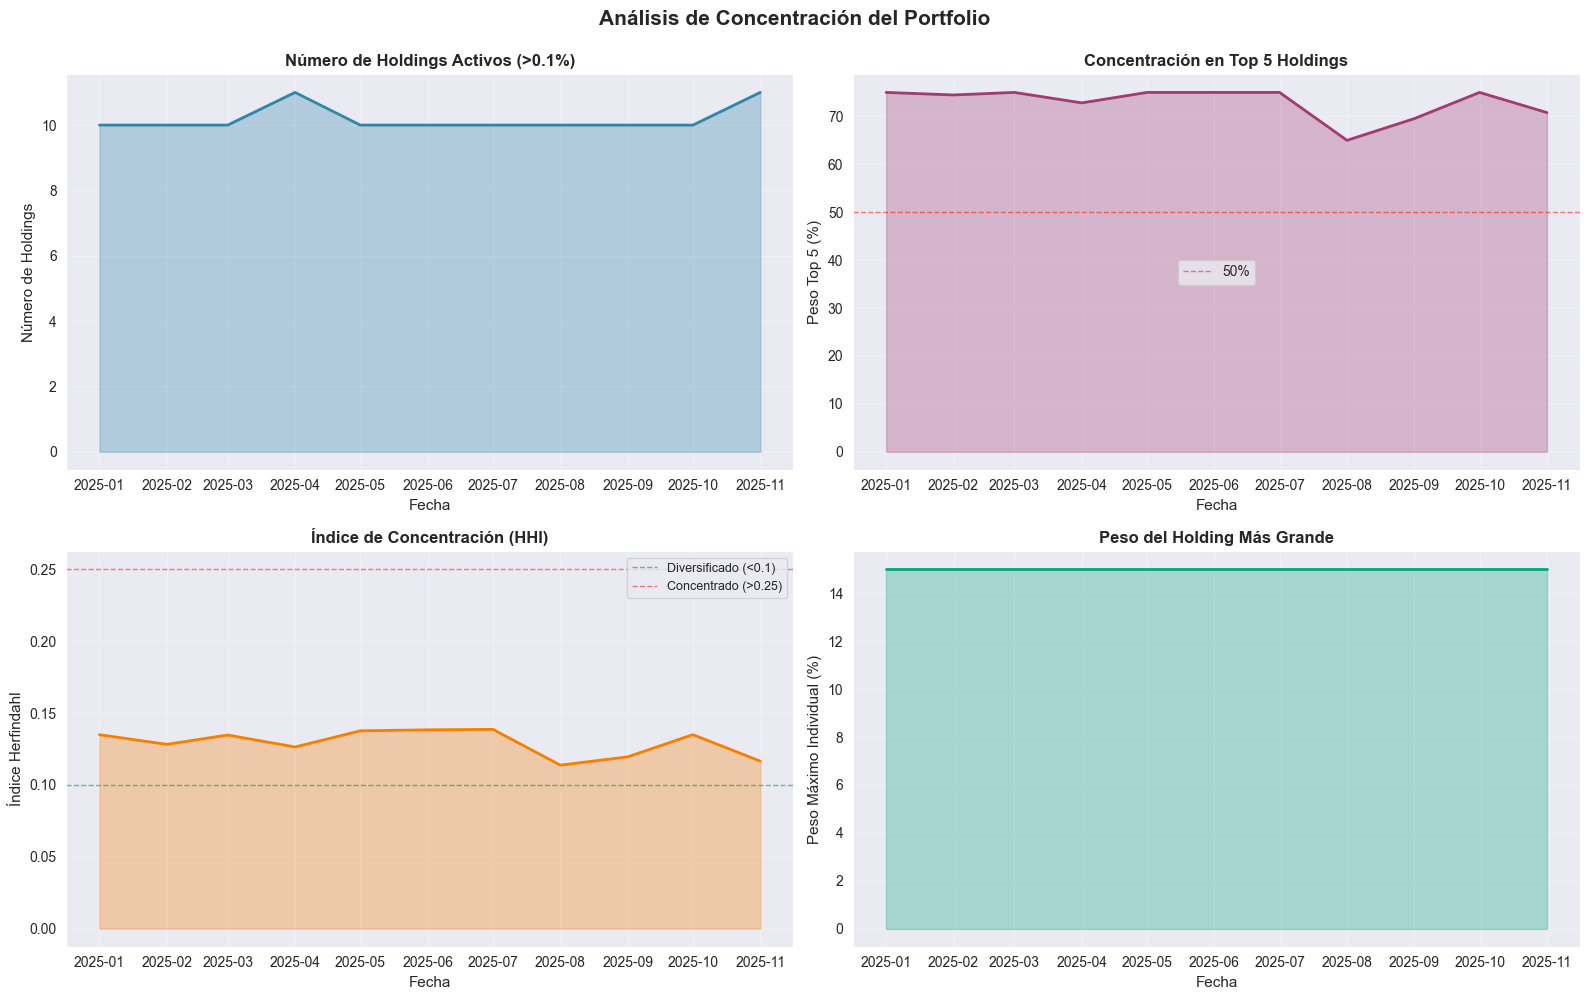

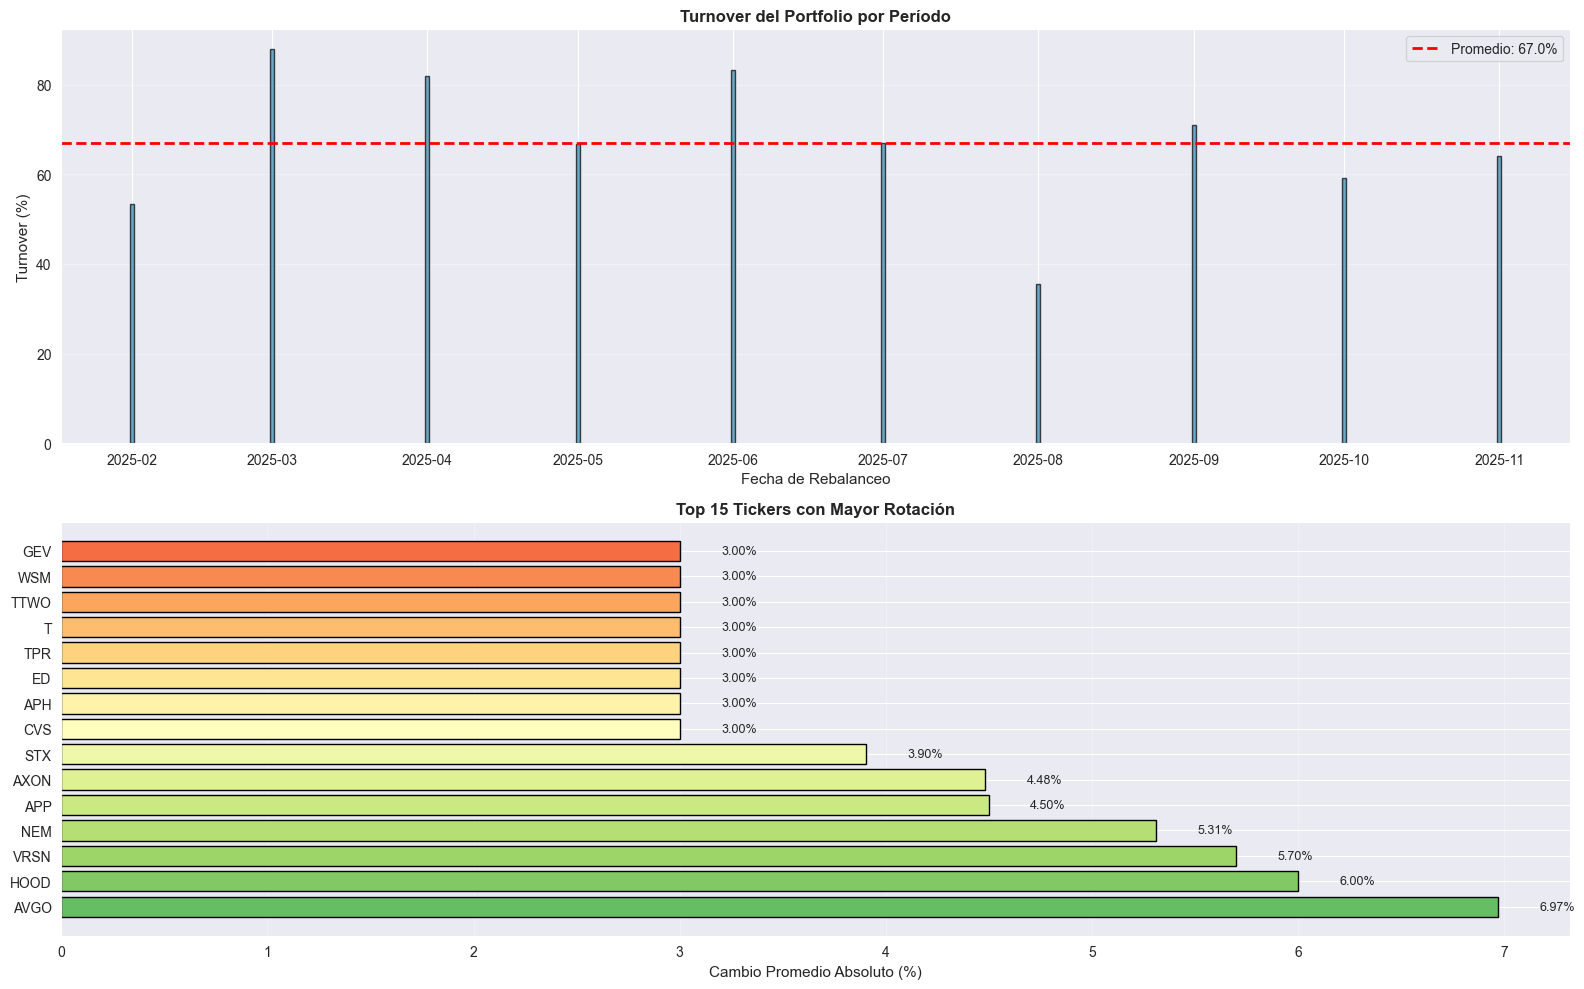


ESTADÍSTICAS DE COMPOSICIÓN DEL PORTFOLIO

Número total de tickers disponibles: 498
Número de períodos de rebalanceo: 11

Holdings activos (>0.1%):
  Promedio: 10.2
  Mínimo: 10
  Máximo: 11

Concentración:
  Peso promedio Top 5: 73.0%
  Peso promedio Top 10: 99.6%
  HHI promedio: 0.1295
  Interpretación: Moderadamente concentrado

Top 10 tickers más frecuentes:
  STX      - Presente en  5/11 períodos ( 45.5%) - Peso prom: 12.49%
  AVGO     - Presente en  5/11 períodos ( 45.5%) - Peso prom: 11.18%
  PLTR     - Presente en  4/11 períodos ( 36.4%) - Peso prom:  5.05%
  WDC      - Presente en  4/11 períodos ( 36.4%) - Peso prom: 11.69%
  NEM      - Presente en  4/11 períodos ( 36.4%) - Peso prom: 10.84%
  HOOD     - Presente en  3/11 períodos ( 27.3%) - Peso prom: 13.75%
  AXON     - Presente en  3/11 períodos ( 27.3%) - Peso prom: 14.79%
  PM       - Presente en  3/11 períodos ( 27.3%) - Peso prom: 10.50%
  APP      - Presente en  3/11 períodos ( 27.3%) - Peso prom: 15.00%
  ORCL     - 

In [12]:
df_weights = pd.DataFrame(portfolio_weights).set_index('Date').fillna(0)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Asumiendo que tienes df_weights con columnas: Date (index) y un peso para cada ticker
# df_weights = DataFrame con index=fechas de rebalanceo, columns=tickers, values=pesos

# ============================================================================
# 1. STACKED AREA CHART - Evolución de pesos en el tiempo
# ============================================================================

def plot_portfolio_composition_area(df_weights, top_n=10):
    """
    Gráfico de áreas apiladas mostrando la evolución de pesos
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Calcular el peso promedio de cada ticker
    avg_weights = df_weights.mean().sort_values(ascending=False)
    
    # Seleccionar top N tickers
    top_tickers = avg_weights.head(top_n).index.tolist()
    
    # Agrupar el resto como "Others"
    df_plot = df_weights[top_tickers].copy()
    df_plot['Others'] = df_weights.drop(columns=top_tickers).sum(axis=1)
    
    # Crear el stacked area plot
    ax.stackplot(df_plot.index, 
                 [df_plot[col].values for col in df_plot.columns],
                 labels=df_plot.columns,
                 alpha=0.8)
    
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Peso en el Portfolio', fontsize=12)
    ax.set_title(f'Evolución de la Composición del Portfolio (Top {top_n} Tickers)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    # Formato del eje Y como porcentaje
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    
    plt.tight_layout()
    return fig

# ============================================================================
# 2. HEATMAP - Pesos de todos los tickers en el tiempo
# ============================================================================

def plot_weights_heatmap(df_weights, min_weight=0.01):
    """
    Heatmap mostrando qué tickers están activos y con qué peso
    Filtra tickers que nunca tuvieron peso > min_weight
    """
    # Filtrar tickers que al menos una vez tuvieron peso significativo
    significant_tickers = df_weights.columns[df_weights.max() > min_weight]
    df_filtered = df_weights[significant_tickers]
    
    # Ordenar tickers por peso promedio
    ticker_order = df_filtered.mean().sort_values(ascending=False).index
    df_filtered = df_filtered[ticker_order]
    
    fig, ax = plt.subplots(figsize=(16, max(10, len(df_filtered.columns) * 0.3)))
    
    # Crear heatmap
    sns.heatmap(df_filtered.T, 
                cmap='YlOrRd', 
                cbar_kws={'label': 'Peso en Portfolio'},
                linewidths=0.5,
                linecolor='white',
                ax=ax)
    
    ax.set_xlabel('Fecha de Rebalanceo', fontsize=12)
    ax.set_ylabel('Ticker', fontsize=12)
    ax.set_title(f'Heatmap de Pesos del Portfolio (Tickers con peso > {min_weight*100:.0f}%)', 
                 fontsize=14, fontweight='bold')
    
    # Rotar labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return fig

# ============================================================================
# 3. TOP HOLDINGS POR PERÍODO
# ============================================================================

def plot_top_holdings_bars(df_weights, n_periods=6, top_n=8):
    """
    Gráfico de barras mostrando top holdings en diferentes períodos
    """
    # Seleccionar períodos espaciados uniformemente
    n_total = len(df_weights)
    indices = np.linspace(0, n_total-1, min(n_periods, n_total), dtype=int)
    selected_dates = df_weights.index[indices]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, (date, ax) in enumerate(zip(selected_dates, axes)):
        if idx >= len(selected_dates):
            ax.axis('off')
            continue
            
        weights = df_weights.loc[date].sort_values(ascending=False).head(top_n)
        
        colors = plt.cm.viridis(np.linspace(0, 0.8, len(weights)))
        bars = ax.barh(range(len(weights)), weights.values, color=colors)
        ax.set_yticks(range(len(weights)))
        ax.set_yticklabels(weights.index)
        ax.set_xlabel('Peso', fontsize=10)
        ax.set_title(f'{date.strftime("%Y-%m-%d")}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Añadir valores en las barras
        for i, (bar, val) in enumerate(zip(bars, weights.values)):
            ax.text(val + 0.01, i, f'{val*100:.1f}%', 
                   va='center', fontsize=9)
        
        ax.set_xlim(0, max(weights.values) * 1.15)
    
    plt.suptitle(f'Top {top_n} Holdings en Diferentes Períodos', 
                 fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

# ============================================================================
# 4. ANÁLISIS DE CONCENTRACIÓN
# ============================================================================

def plot_concentration_analysis(df_weights):
    """
    Analiza la concentración del portfolio en el tiempo
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 4.1. Número de holdings activos
    ax1 = axes[0, 0]
    n_holdings = (df_weights > 0.001).sum(axis=1)  # Tickers con >0.1%
    ax1.plot(df_weights.index, n_holdings, linewidth=2, color='#2E86AB')
    ax1.fill_between(df_weights.index, n_holdings, alpha=0.3, color='#2E86AB')
    ax1.set_ylabel('Número de Holdings', fontsize=11)
    ax1.set_xlabel('Fecha', fontsize=11)
    ax1.set_title('Número de Holdings Activos (>0.1%)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 4.2. Peso del Top 5
    ax2 = axes[0, 1]
    top5_weight = df_weights.apply(lambda x: x.nlargest(5).sum(), axis=1)
    ax2.plot(df_weights.index, top5_weight * 100, linewidth=2, color='#A23B72')
    ax2.fill_between(df_weights.index, top5_weight * 100, alpha=0.3, color='#A23B72')
    ax2.set_ylabel('Peso Top 5 (%)', fontsize=11)
    ax2.set_xlabel('Fecha', fontsize=11)
    ax2.set_title('Concentración en Top 5 Holdings', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50%')
    ax2.legend()
    
    # 4.3. Índice Herfindahl (HHI) - Mide concentración
    ax3 = axes[1, 0]
    hhi = (df_weights ** 2).sum(axis=1)
    ax3.plot(df_weights.index, hhi, linewidth=2, color='#F77F00')
    ax3.fill_between(df_weights.index, hhi, alpha=0.3, color='#F77F00')
    ax3.set_ylabel('Índice Herfindahl', fontsize=11)
    ax3.set_xlabel('Fecha', fontsize=11)
    ax3.set_title('Índice de Concentración (HHI)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0.1, color='green', linestyle='--', linewidth=1, alpha=0.5, 
                label='Diversificado (<0.1)')
    ax3.axhline(y=0.25, color='red', linestyle='--', linewidth=1, alpha=0.5, 
                label='Concentrado (>0.25)')
    ax3.legend(fontsize=9)
    
    # 4.4. Peso máximo individual
    ax4 = axes[1, 1]
    max_weight = df_weights.max(axis=1)
    ax4.plot(df_weights.index, max_weight * 100, linewidth=2, color='#06A77D')
    ax4.fill_between(df_weights.index, max_weight * 100, alpha=0.3, color='#06A77D')
    ax4.set_ylabel('Peso Máximo Individual (%)', fontsize=11)
    ax4.set_xlabel('Fecha', fontsize=11)
    ax4.set_title('Peso del Holding Más Grande', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Análisis de Concentración del Portfolio', 
                 fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

# ============================================================================
# 5. ANÁLISIS DE ROTACIÓN (TURNOVER)
# ============================================================================

def plot_turnover_analysis(df_weights):
    """
    Analiza cuánto cambian los pesos entre rebalanceos
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Calcular turnover (suma de cambios absolutos / 2)
    turnover = df_weights.diff().abs().sum(axis=1) / 2
    turnover = turnover.iloc[1:]  # Quitar el primer NaN
    
    # 5.1. Turnover por período
    ax1 = axes[0]
    ax1.bar(turnover.index, turnover * 100, color='#2E86AB', alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Turnover (%)', fontsize=11)
    ax1.set_xlabel('Fecha de Rebalanceo', fontsize=11)
    ax1.set_title('Turnover del Portfolio por Período', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=turnover.mean() * 100, color='red', linestyle='--', 
                linewidth=2, label=f'Promedio: {turnover.mean()*100:.1f}%')
    ax1.legend(fontsize=10)
    
    # 5.2. Tickers que más cambian
    ax2 = axes[1]
    avg_abs_change = df_weights.diff().abs().mean().sort_values(ascending=False).head(15)
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(avg_abs_change)))
    bars = ax2.barh(range(len(avg_abs_change)), avg_abs_change.values * 100, 
                    color=colors, edgecolor='black')
    ax2.set_yticks(range(len(avg_abs_change)))
    ax2.set_yticklabels(avg_abs_change.index)
    ax2.set_xlabel('Cambio Promedio Absoluto (%)', fontsize=11)
    ax2.set_title('Top 15 Tickers con Mayor Rotación', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores
    for i, (bar, val) in enumerate(zip(bars, avg_abs_change.values)):
        ax2.text(val * 100 + 0.2, i, f'{val*100:.2f}%', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    return fig

# ============================================================================
# 6. ESTADÍSTICAS DE COMPOSICIÓN
# ============================================================================

def print_composition_stats(df_weights):
    """
    Imprime estadísticas sobre la composición del portfolio
    """
    print("\n" + "="*80)
    print("ESTADÍSTICAS DE COMPOSICIÓN DEL PORTFOLIO")
    print("="*80)
    
    # Estadísticas básicas
    print(f"\nNúmero total de tickers disponibles: {len(df_weights.columns)}")
    print(f"Número de períodos de rebalanceo: {len(df_weights)}")
    
    # Holdings activos
    avg_holdings = (df_weights > 0.001).sum(axis=1).mean()
    min_holdings = (df_weights > 0.001).sum(axis=1).min()
    max_holdings = (df_weights > 0.001).sum(axis=1).max()
    
    print(f"\nHoldings activos (>0.1%):")
    print(f"  Promedio: {avg_holdings:.1f}")
    print(f"  Mínimo: {min_holdings}")
    print(f"  Máximo: {max_holdings}")
    
    # Concentración
    avg_top5 = df_weights.apply(lambda x: x.nlargest(5).sum(), axis=1).mean()
    avg_top10 = df_weights.apply(lambda x: x.nlargest(10).sum(), axis=1).mean()
    avg_hhi = (df_weights ** 2).sum(axis=1).mean()
    
    print(f"\nConcentración:")
    print(f"  Peso promedio Top 5: {avg_top5*100:.1f}%")
    print(f"  Peso promedio Top 10: {avg_top10*100:.1f}%")
    print(f"  HHI promedio: {avg_hhi:.4f}")
    
    if avg_hhi < 0.1:
        concentration = "Bien diversificado"
    elif avg_hhi < 0.18:
        concentration = "Moderadamente concentrado"
    else:
        concentration = "Altamente concentrado"
    print(f"  Interpretación: {concentration}")
    
    # Tickers más frecuentes
    presence = (df_weights > 0.001).sum()
    most_frequent = presence.sort_values(ascending=False).head(10)
    
    print(f"\nTop 10 tickers más frecuentes:")
    for ticker, count in most_frequent.items():
        pct = (count / len(df_weights)) * 100
        avg_weight = df_weights[df_weights[ticker] > 0.001][ticker].mean()
        print(f"  {ticker:8} - Presente en {count:2d}/{len(df_weights)} períodos ({pct:5.1f}%) - Peso prom: {avg_weight*100:5.2f}%")
    
    # Tickers con mayor peso promedio
    avg_weights = df_weights[df_weights > 0.001].mean()
    top_weights = avg_weights.sort_values(ascending=False).head(10)
    
    print(f"\nTop 10 tickers por peso promedio:")
    for ticker, weight in top_weights.items():
        presence_count = (df_weights[ticker] > 0.001).sum()
        print(f"  {ticker:8} - Peso prom: {weight*100:5.2f}% - Presente: {presence_count}/{len(df_weights)}")
    
    # Turnover
    turnover = df_weights.diff().abs().sum(axis=1) / 2
    avg_turnover = turnover.mean()
    
    print(f"\nRotación (Turnover):")
    print(f"  Turnover promedio por rebalanceo: {avg_turnover*100:.1f}%")
    print(f"  Turnover mínimo: {turnover.min()*100:.1f}%")
    print(f"  Turnover máximo: {turnover.max()*100:.1f}%")
    
    print("="*80)

# ============================================================================
# EJECUTAR TODOS LOS ANÁLISIS
# ============================================================================

# 1. Evolución temporal (Stacked Area)
fig1 = plot_portfolio_composition_area(df_weights, top_n=10)
plt.show()

# 2. Heatmap
fig2 = plot_weights_heatmap(df_weights, min_weight=0.02)
plt.show()

# 3. Top holdings por período
fig3 = plot_top_holdings_bars(df_weights, n_periods=6, top_n=8)
plt.show()

# 4. Análisis de concentración
fig4 = plot_concentration_analysis(df_weights)
plt.show()

# 5. Análisis de turnover
fig5 = plot_turnover_analysis(df_weights)
plt.show()

# 6. Estadísticas textuales
print_composition_stats(df_weights)